# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. \
Нам предоставлен набор фотографий людей с указанием возраста.

Нам нужно решить задачу регрессии.

Данные взяты с сайта ChaLearn Looking at People. \
Они находятся в папке /datasets/faces/. \
В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 

## Исследовательский анализ данных

### Загрузка и импорты

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from PIL import Image

In [2]:
images_path = '/datasets/faces/final_files/'
df = pd.read_csv('/datasets/faces/labels.csv')

### Обзор данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет. Формат возраста корректный.

In [4]:
# Посмотрим на размер выборки
df.shape

(7591, 2)

In [5]:
# Визуализируем несколько строк выборки
df.sample(5)

,file_name,real_age
6034,006037.jpg,15
7315,007337.jpg,30
3341,003341.jpg,27
6118,006121.jpg,95
3199,003199.jpg,19


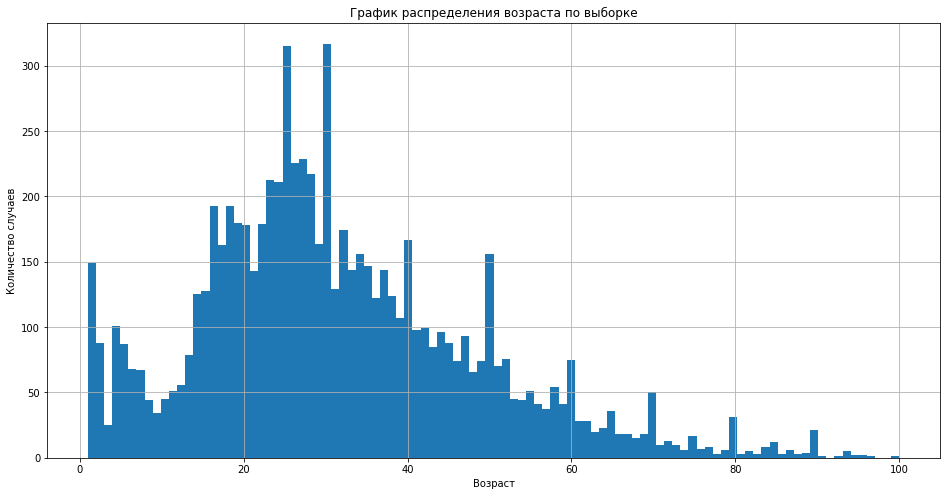

In [6]:
# Выведем гистограмму распределения возврастов
plt.figure(figsize=(16, 8))
df['real_age'].hist(bins=100)
plt.title('График распределения возраста по выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество случаев')
plt.show()

Пик в районе 25-30 лет. Второй пик в районе 2 лет. График скошен влево. Выборка несбалансированна, доволно мало фото диапазонов 6-14 лет и 50+.
Наблюдаются локальные выбросы в районе 'круглых' значений. Видимо при проведении опроса люди были склонны округлять свой возраст, это может повлиять на точность определения возраста моделью.

Выведем 15 фотографий. 

Found 7591 validated image filenames.


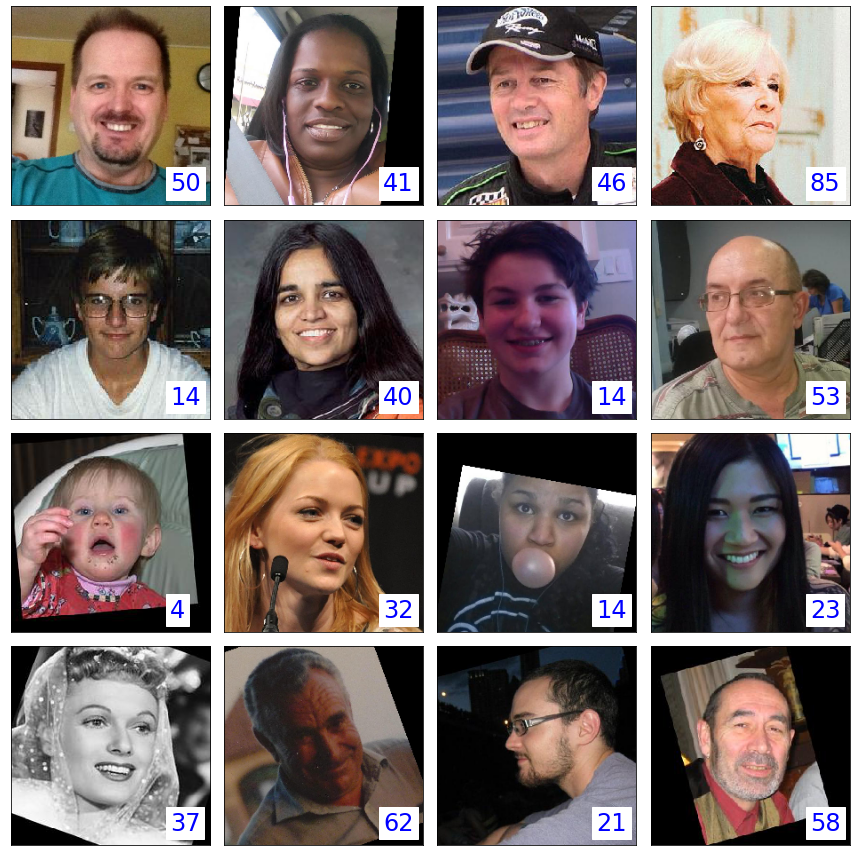

In [7]:
datagen = ImageDataGenerator(rescale=1./255) 

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe = df,
    directory = images_path,
    x_col = 'file_name',
    y_col = 'real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    seed=12345)

x, y = next(train_datagen_flow)
fig = plt.figure(figsize=(12,12))
for i in range(16):
    ax = fig.add_subplot(4,4, i+1)
    plt.imshow(x[i])
    plt.text(0.8, 0.075, y[i], fontsize = 24, transform=ax.transAxes, color='blue', backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На первый взглад возраст выводится корректно. Лица расположены в центре, хорошо различимы.

Приступим к обучению модели.

## Обучение модели

Обучим модель в GPU-сервере и сохраним результат вывода модели на экран.

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python
import pandas as pd

from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123
    )
    return train_gen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )
    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=2,
                                   restore_best_weights=True)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[early_stopping],
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-01-16 21:38:28.612204: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-01-16 21:38:29.795551: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 64s - loss: 242.8628 - mae: 11.1847 - val_loss: 856.3839 - val_mae: 24.2228
Epoch 2/10
178/178 - 40s - loss: 76.9926 - mae: 6.6128 - val_loss: 813.7845 - val_mae: 23.4450
Epoch 3/10
178/178 - 39s - loss: 50.1360 - mae: 5.3366 - val_loss: 276.2372 - val_mae: 12.3805
Epoch 4/10
178/178 - 39s - loss: 36.1723 - mae: 4.6360 - val_loss: 106.6929 - val_mae: 7.9215
Epoch 5/10
178/178 - 39s - loss: 25.9981 - mae: 3.9064 - val_loss: 84.8142 - val_mae: 6.8982
Epoch 6/10
178/178 - 39s - loss: 21.4242 - mae: 3.5317 - val_loss: 66.3373 - val_mae: 6.0849
Epoch 7/10
178/178 - 38s - loss: 16.8593 - mae: 3.1241 - val_loss: 72.7223 - val_mae: 6.3460
Epoch 8/10
178/178 - 39s - loss: 13.7959 - mae: 2.8436 - val_loss: 97.6862 - val_mae: 7.2897
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 66.3373 - mae: 6.0849
Test MAE: 6.0849

```

Ошибка модели на тестовых данных ~ +-6 лет. 

## Анализ обученной модели

Нам необходимо было обучить модель, которая помогала бы решить задачи бизнеса:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Для обучения, мы выбрали предобученную на датасете ImageNet нейронную сеть на основании архитектуры ResNet50. Расширили обучающий датасет с помощью аугментации - выбрали горизонтальное отражение фотографий. \
Так как перед нами стояла задача регрессии определения возраста, мы использовали функцию потерь MSE и метрику MAE. \
При обучении использовали раннюю остановку EarlyStopping, чтобы прекратить обучение, если функция потерь на валидационных данных не улучшается в течение нескольких эпох, дополнительно прописав, чтобы нам вернулись наиболее результативные веса модели.
Мы протестировали модель на разном количестве эпох и скорости обучения, и выбрали наиболее оптимальный вариант. 

По результатам работы мы смогли обучить модель с метрикой MAE равной ~6 годам, это значит, что наша модель может ошибаться на +- 6 лет. 

Данная модель подходит для решения задачи предложения товаров покупателям разных возрастных групп, но для контроля добросовестности кассиров при продаже алкоголя, ошибка в 6 лет будет критической. 

Учитывая, что на графике наблюдались локальные пики в районе 'круглых' цифр, можно предполагать, что опрос людей изображенных на фото проводился без документального подтверждения возраста, либо сотавитель датасета определял его примерно, поэтому возможно искажение данных из-за склонности людей округлять возраст, это могло повлиять на качество предсказаний модели.

Для повышения качества предсказаний, рекомендуется собрать более сбалансированную выборку, а также определять возраст на основе документов.